# Develop `tide_stn_water_level` Figure Module

Development of functions for `nowcast.figures.fvcom.tide_stn_water_level` web site figure module.

In [1]:
from contextlib import suppress
from datetime import timedelta
from pathlib import Path
import shlex
import subprocess
from types import SimpleNamespace

import arrow
import matplotlib.dates
import matplotlib.pyplot as plt
import requests
import xarray
from salishsea_tools import data_tools
from salishsea_tools.places import PLACES

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_get_ssh_forecast()` Function

In [3]:
def _get_nemo_ssh(place, dataset_url_tmpl):
    ## TODO: This is a work-around because neither netCDF4 nor xarray are able
    ## to load the dataset directly from the URL due to an OpenDAP issue
    dataset_url = dataset_url_tmpl.format(place=place.replace(" ", ""))
    dataset_id = dataset_url.rsplit('/', 1)[1]
    ssh_file = Path('/tmp').joinpath(dataset_id).with_suffix('.nc')
    with ssh_file.open('wb') as f:
        resp = requests.get(f'{dataset_url}.nc')
        f.write(resp.content)
    try:
        nemo_ssh = xarray.open_dataset(ssh_file)
    except OSError:
        raise ValueError(f'NEMO ssh dataset not found for {place}')
    return nemo_ssh

## `_prep_plot_data()` Function

In [4]:
def _prep_plot_data(place, fvcom_ssh_dataset, nemo_ssh_dataset_url_tmpl):
    # FVCOM sea surface height dataset
    fvcom_ssh = fvcom_ssh_dataset.zeta.isel(
        station=[
            name.decode().strip().split(maxsplit=1)[1] 
            for name in fvcom_ssh_dataset.name_station.values
        ].index(place))
    fvcom_period = slice(
        str(fvcom_ssh.time.values[0]), str(fvcom_ssh.time.values[-1])
    )
    # NEMO sea surface height dataset
    try:
        nemo_ssh = _get_nemo_ssh(place, nemo_ssh_dataset_url_tmpl).sel(time=fvcom_period)
    except ValueError:
        # No NEMO sea surface height dataset for place
        nemo_ssh = None
    # CHS water level observations dataset
    try:
        obs_1min = data_tools.get_chs_tides(
            'obs',
            place,
            arrow.get(fvcom_period.start) - timedelta(seconds=5 * 60),
            arrow.get(fvcom_period.stop)
        )
        obs = xarray.Dataset({
            'water_level': xarray.DataArray(obs_1min).rename({
                'dim_0': 'time'
            })
        })
    except TypeError:
        # Invalid tide gauge station number, probably None
        obs = None
    # CHS water level predictions dataset
    try:
        pred_place = 'Point Atkinson' if place == 'Sandy Cove' else place
        pred = data_tools.get_chs_tides(
            'pred', pred_place, arrow.get(fvcom_period.start),
            arrow.get(fvcom_period.stop)
        )
        pred = xarray.Dataset({
            'water_level':
                xarray.DataArray.from_series(pred).rename({
                    'index': 'time'
                })
        })
    except TypeError:
        # Invalid tide gauge station number, probably None
        pred = None
    # Change dataset times to Pacific time zone
    shared.localize_time(fvcom_ssh)
    with suppress(AttributeError):
        shared.localize_time(nemo_ssh)
    with suppress(IndexError, AttributeError):
        shared.localize_time(obs)
    with suppress(IndexError, AttributeError):
        shared.localize_time(pred)
    # Mean sea level
    msl = PLACES[place]['mean sea lvl']
    return SimpleNamespace(
        fvcom_ssh=fvcom_ssh,
        nemo_ssh=nemo_ssh,
        obs=obs,
        pred=pred,
        msl=msl,
    )

## `_prep_fig_axes()` Function

In [5]:
def _prep_fig_axes(figsize, theme):
    fig, ax = plt.subplots(
        1, 1, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    fig.autofmt_xdate()
    return fig, ax


## `_plot_water_level_time_series()` Function

In [6]:
def _plot_water_level_time_series(ax, place, plot_data, theme):
    with suppress(AttributeError):
        # CHS sometimes returns an empty prediction dataset
        if plot_data.pred.water_level.size:
            plot_data.pred.water_level.plot(
                ax=ax,
                linewidth=2,
                label='CHS Predicted',
                color=theme.COLOURS['time series']['tidal prediction']
            )
    with suppress(AttributeError):
        # CHS sometimes returns an empty observations dataset
        if plot_data.obs.water_level.size:
            plot_data.obs.water_level.plot(
                ax=ax,
                linewidth=2,
                label='CHS Observed',
                color=theme.COLOURS['time series']['tide gauge obs']
            )
    with suppress(AttributeError):
        (plot_data.nemo_ssh.ssh + plot_data.msl).plot(
            ax=ax,
            linewidth=2,
            label='NEMO',
            color=theme.COLOURS['time series']['tide gauge ssh']
        )
    (plot_data.fvcom_ssh + plot_data.msl).plot(
        ax=ax,
        linewidth=2,
        label='FVCOM',
        color=theme.COLOURS['time series']['vhfr fvcom ssh']
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _water_level_time_series_labels(ax, place, plot_data, theme)


## `_water_level_time_series_labels()` Function

In [7]:
def _water_level_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Water Level at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_xlabel(
        f'Time [{plot_data.fvcom_ssh.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    ax.set_ylabel(
        'Water Level above Chart Datum [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)


## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [8]:
def make_figure(place,
                fvcom_ssh_dataset_path,
                nemo_ssh_dataset_url_tmpl,
                figsize=(16, 9),
                theme=nowcast.figures.website_theme):
    plot_data = _prep_plot_data(place, fvcom_ssh_dataset_path, nemo_ssh_dataset_url_tmpl)
    fig, ax = _prep_fig_axes(figsize, theme)
    _plot_water_level_time_series(ax, place, plot_data, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

### Nowcast Figure

16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


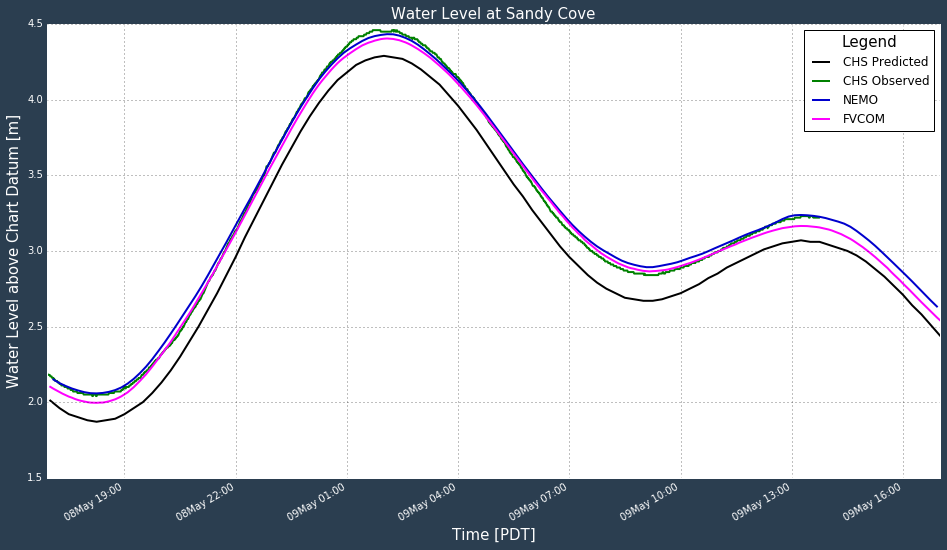

In [9]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

run_type = 'nowcast'
run_date = arrow.get('2018-05-09')

fvcom_ssh_dataset_path_tmpl = '/opp/fvcom/{run_type}/{ddmmmyy}/vhfr_low_v2_station_timeseries.nc'
if run_type == 'nowcast':
    fvcom_ssh_dataset_path = Path(
        fvcom_ssh_dataset_path_tmpl.format(run_type=run_type, ddmmmyy=run_date.format("DDMMMYY").lower())
    )
else:
    nowcast_dataset_path = Path(
        fvcom_ssh_dataset_path_tmpl.format(run_type=run_type, ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    forecast_dataset_path = Path(
        fvcom_ssh_dataset_path_tmpl.format(run_type=run_type, ddmmmyy=run_date.replace(days=+1).format("DDMMMYY").lower())
    )
    fvcom_ssh_dataset_path = '/tmp/vhfr_low_v2_station_timeseries_forecast.nc'
    cmd = f'ncrcat {nowcast_dataset_path} {forecast_dataset_path} -o {fvcom_ssh_dataset_path}'
    subprocess.check_output(shlex.split(cmd))
cmd = (
    f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
    f'{fvcom_ssh_dataset_path} /tmp/{fvcom_ssh_dataset_path.name}')
subprocess.check_output(shlex.split(cmd))
fvcom_ssh_dataset = xarray.open_dataset(f'/tmp/{fvcom_ssh_dataset_path.name}')

nemo_ssh_dataset_url_tmpl = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf{place}SSH10mV17-02'

fig = make_figure('Sandy Cove', fvcom_ssh_dataset, nemo_ssh_dataset_url_tmpl)

### Forecast Figure

16.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


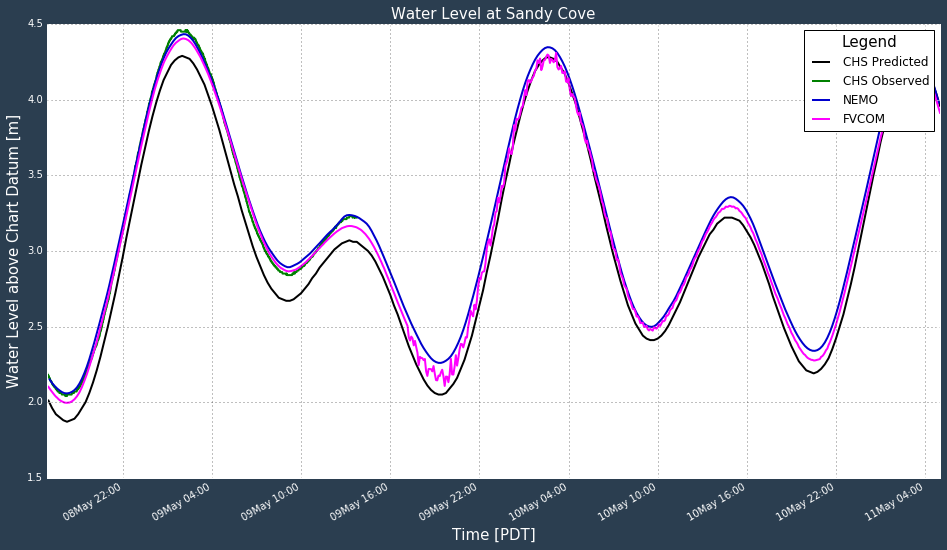

In [10]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

run_type = 'forecast'
run_date = arrow.get('2018-05-09')

fvcom_ssh_dataset_path_tmpl = '/opp/fvcom/{run_type}/{ddmmmyy}/vhfr_low_v2_station_timeseries.nc'
if run_type == 'nowcast':
    fvcom_ssh_dataset_path = Path(
        fvcom_ssh_dataset_path_tmpl.format(run_type=run_type, ddmmmyy=run_date.format("DDMMMYY").lower())
    )
else:
    nowcast_dataset_path = Path(
        fvcom_ssh_dataset_path_tmpl.format(run_type='nowcast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    forecast_dataset_path = Path(
        fvcom_ssh_dataset_path_tmpl.format(run_type='forecast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    fvcom_ssh_dataset_path = Path('/tmp/vhfr_low_v2_station_timeseries_forecast.nc')
    cmd = f'ncrcat -O {nowcast_dataset_path} {forecast_dataset_path} -o {fvcom_ssh_dataset_path}'
    subprocess.check_output(shlex.split(cmd))
cmd = (
    f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
    f'{fvcom_ssh_dataset_path} /tmp/{fvcom_ssh_dataset_path.name}')
subprocess.check_output(shlex.split(cmd))
fvcom_ssh_dataset = xarray.open_dataset(f'/tmp/{fvcom_ssh_dataset_path.name}')

nemo_ssh_dataset_url_tmpl = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf{place}SSH10mV17-02'

fig = make_figure('Sandy Cove', fvcom_ssh_dataset, nemo_ssh_dataset_url_tmpl)